In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [3]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [4]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [13]:
df.shape

(35887, 2)

The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [28]:
## parsing data here
images, labels = parse_data(df)


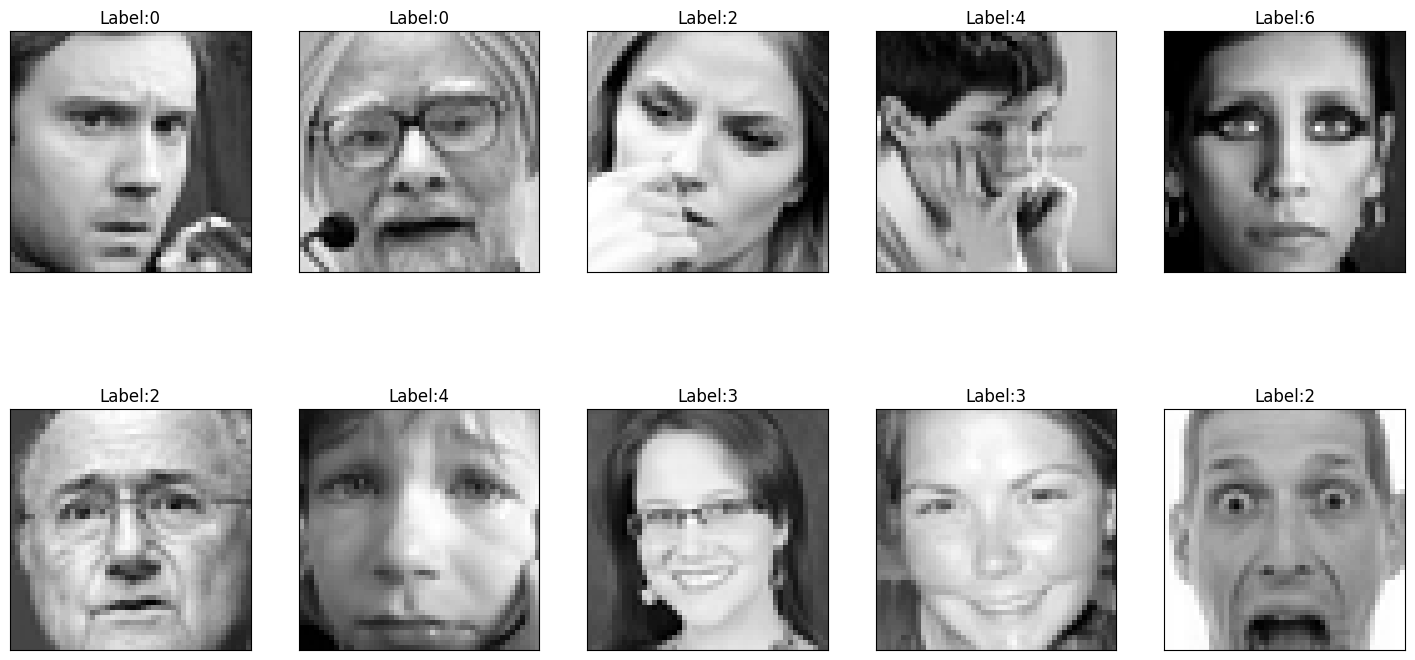

In [11]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [46]:
flattened_images = images.reshape(images.shape[0], -1)

In [60]:
# fit with pca
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(flattened_images)

PCA()

In [61]:
## transform for visualizing here
images_pca=pca.transform(flattened_images) ## modify images' array to the appropriate shape
images_pca.shape

(35887, 2304)

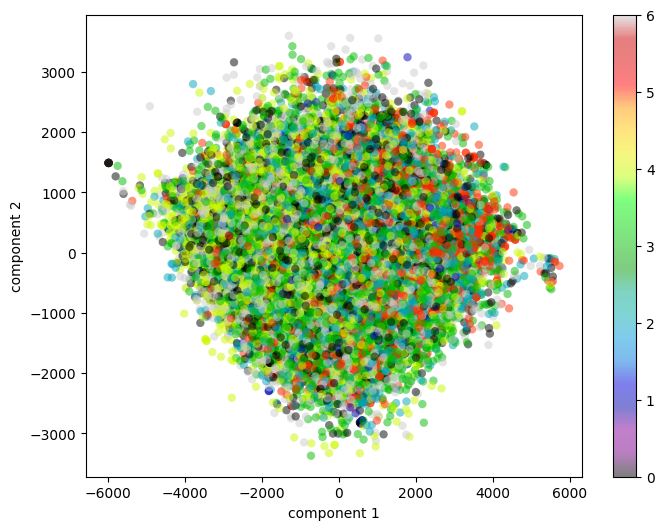

In [62]:
# visualize 2 components on 2D graph
plt.figure(figsize=(8, 6))

plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, edgecolor='none', alpha=0.5,
            cmap='nipy_spectral')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

In [63]:
## determine the optimal number of PCs here
pca.explained_variance_

array([2.66512420e+06, 9.03136454e+05, 8.68414944e+05, ...,
       4.29082479e+00, 4.17553368e+00, 3.85456269e+00])

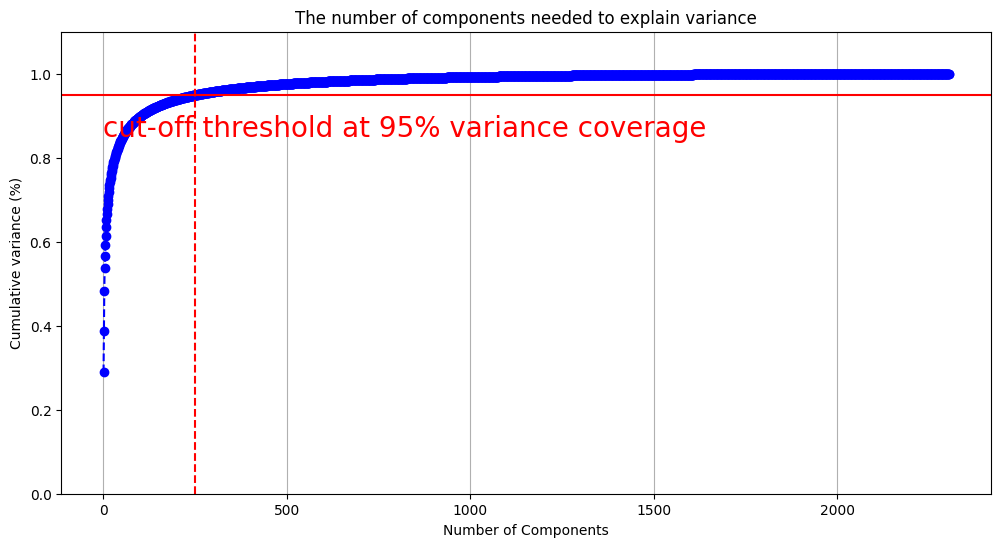

In [74]:
# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(cumulative_variance)+1, step=1)
y = cumulative_variance

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, 'cut-off threshold at 95% variance coverage', color = 'red', fontsize=20)


ax.grid(axis='x')
# add vertical line that cut of axhline and the plot
plt.axvline(x=250, color='r', linestyle='--')
plt.show()

In [75]:
# choose optimal number of PCs

pca = PCA(n_components=250)
pca.fit(flattened_images)

PCA(n_components=250)

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [96]:
## splitting data into train/val/test subsets here

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(flattened_images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## fitting the model
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [97]:
from sklearn.metrics import accuracy_score

In [98]:
## training accuracy

y_pred = clf.predict(X_val)
accuracy_score(y_val, y_pred)

0.455067920585162

In [99]:
## test validation

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.45374756199498467

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



              precision    recall  f1-score   support

           0       0.46      0.22      0.29       985
           1       1.00      0.27      0.43       102
           2       0.45      0.28      0.35      1043
           3       0.44      0.76      0.56      1765
           4       0.36      0.37      0.37      1210
           5       0.68      0.52      0.59       795
           6       0.45      0.39      0.42      1278

    accuracy                           0.45      7178
   macro avg       0.55      0.40      0.43      7178
weighted avg       0.47      0.45      0.44      7178



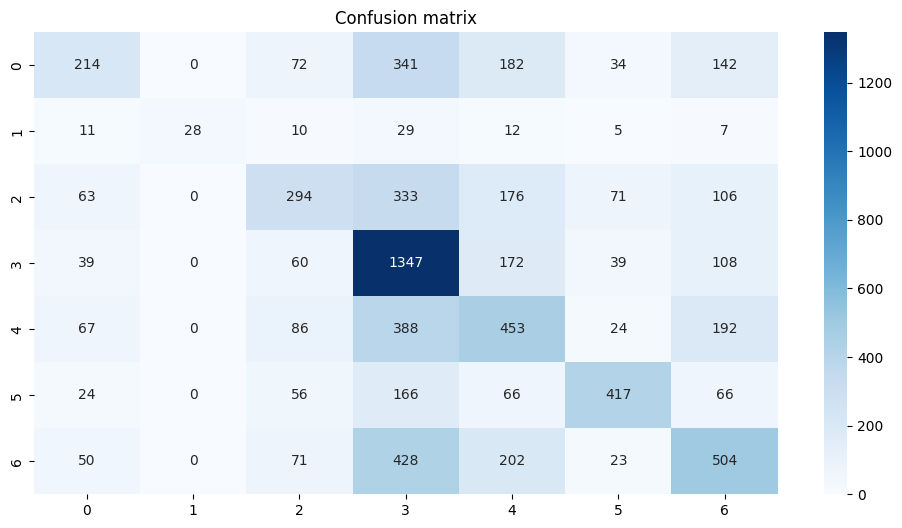

In [100]:
## visualize the confusion matrices and classification reports here

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def eval(y_true, y_pred, class_names, title='Confusion matrix'):
    print(classification_report(y_true, y_pred))
    matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix, cmap='Blues', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.show()

eval(y_test, y_pred, clf.classes_, title='Confusion matrix')

In [104]:
# Do the same with MLP

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(48, 48), max_iter=300, random_state=42)

clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(48, 48), max_iter=300, random_state=42)

In [105]:
y_pred = clf.predict(X_val)
accuracy_score(y_val, y_pred)

0.26419366074538486

In [106]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.2460295346893285